In [1]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../scripts/asset_processor/')
import utils
from video_asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib notebook

In [3]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]

FEATURES_SL = ['temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]
FEATURES_QOE = ['temporal_dct-mean',
            'temporal_gaussian_mse-mean',
            'temporal_gaussian_difference-mean',
            'temporal_threshold_gaussian_difference-mean'
            ]
FEATURES_META = ['cat_r_pred','cat_cl_pred','ocsvm_pred']
METRICS_QOE = ['temporal_ssim-mean']
FULL_FEATURES = list(sorted(set(FEATURES_UL+FEATURES_SL+FEATURES_QOE)))
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [4]:
# read data
data = utils.load_data('../../../data/data-large.csv')
# remove low bitrate renditions
data = data[~data.rendition.str.contains('bitrate')]
data = VideoAssetProcessor.rescale_to_resolution(data, FULL_FEATURES)
len_before = len(data)

Upscaling temporal_dct temporal_dct-mean
Upscaling temporal_gaussian_mse temporal_gaussian_mse-mean
Upscaling temporal_gaussian_difference temporal_gaussian_difference-mean


In [5]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL+FEATURES_QOE+METRICS_QOE, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 11783 NA rows


In [6]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_idx = ~data.index.isin(train_data.index)
test_data = data[test_idx]
y_test = test_data['target']
y_train = train_data['target']
# save split
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [7]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
144p_watermark              529
144p_vignette               529
240p                        529
480p_watermark              529
240p_vignette               529
480p_vignette               529
144p_rotate_90_clockwise    529
360p_rotate_90_clockwise    529
144p                        529
240p_watermark              529
480p_rotate_90_clockwise    529
480p                        529
480p_black_and_white        529
1080p_black_and_white       529
240p_black_and_white        529
Name: rendition, dtype: int64

In [24]:
train_data[FULL_FEATURES].describe()

,size_dimension_ratio,temporal_dct-mean,temporal_gaussian_difference-mean,temporal_gaussian_mse-mean,temporal_threshold_gaussian_difference-mean
count,126181.000000,1.261810e+05,1.261810e+05,126181.000000,126181.000000
mean,3.258748,9.222377e+06,4.200714e+09,9620.536806,21543.205722
std,1.842008,2.097395e+07,9.360401e+09,28856.402249,26486.857907
min,0.016781,2.105444e+03,2.359221e+06,0.010623,0.000000
25%,2.289029,2.068277e+05,1.356068e+08,50.851090,1346.915254
50%,3.054375,1.204543e+06,5.516112e+08,536.583320,4020.881356
75%,3.721576,6.353473e+06,2.833676e+09,4283.999906,44662.881356
max,35.480671,4.686612e+08,1.687385e+11,876823.514485,129599.000000


In [32]:
(train_data['size']/(train_data['dimension_x']*train_data['dimension_y'])).describe()

count    126181.000000
mean          3.258748
std           1.842008
min           0.016781
25%           2.289029
50%           3.054375
75%           3.721576
max          35.480671
dtype: float64

In [8]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     2780
1    19569
Name: target, dtype: int64

In [9]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
1080p_24-30fps/33S9MmkEJzc.mp4                                      0
1080p_24-30fps/AQKale-lyaA.mp4                                      0
1080p_24-30fps/DlknpJcn1QM.mp4                                      0
1080p_24-30fps/Hw161KRfA5I.mp4                                      0
1080p_50-30fps/GDPLXneWvgc_60.mp4                                   0
144p_flip_vertical_50-30fps/olkMNKt5JZ0_60.mp4                      1
1080p_watermark-856x856_50-60fps/olkMNKt5JZ0_60.mp4                 1
144p_black_and_white_24-60fps_gpu/YRXsFtqOeAI.mp4                   1
1080p_flip_horizontal_24-30fps/5bXqi7ReuVU.mp4                      1
144p_24-60fps_gpu/7n3zr8jIaRY.mp4                                   0
1080p_black_and_white_25-30fps_gpu/vYwhOc3LxpM.mp4                  1
240p_rotate_90_counterclockwise_60-30fps/wDlwhPMrd_k_60.mp4         1
144p_rotate_90_clockwise_25-60fps_gpu/vYwhOc3LxpM.mp4               1
1080p_watermark_25-30fps/r5AKa5aVUvE.mp4                            1
1080p_vignette_24

In [10]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [11]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5677456	total: 57.9ms	remaining: 28.9s
1:	learn: 0.4725166	total: 72.1ms	remaining: 18s
2:	learn: 0.3922937	total: 81.7ms	remaining: 13.5s
3:	learn: 0.3325679	total: 92.8ms	remaining: 11.5s
4:	learn: 0.2819917	total: 103ms	remaining: 10.2s
5:	learn: 0.2395141	total: 114ms	remaining: 9.36s
6:	learn: 0.2070151	total: 124ms	remaining: 8.72s
7:	learn: 0.1818124	total: 133ms	remaining: 8.18s
8:	learn: 0.1630620	total: 143ms	remaining: 7.78s
9:	learn: 0.1481803	total: 153ms	remaining: 7.5s
10:	learn: 0.1354061	total: 163ms	remaining: 7.25s
11:	learn: 0.1246242	total: 173ms	remaining: 7.03s
12:	learn: 0.1161361	total: 183ms	remaining: 6.85s
13:	learn: 0.1095354	total: 193ms	remaining: 6.69s
14:	learn: 0.1040374	total: 202ms	remaining: 6.54s
15:	learn: 0.0991381	total: 212ms	remaining: 6.4s
16:	learn: 0.0951275	total: 222ms	remaining: 6.3s
17:	learn: 0.0919412	total: 232ms	remaining: 6.22s
18:	learn: 0.0889284	total: 244ms	remaining: 6.19s
19:	learn: 0.0863363	total: 254ms	remainin

162:	learn: 0.0594559	total: 1.91s	remaining: 3.96s
163:	learn: 0.0593885	total: 1.93s	remaining: 3.94s
164:	learn: 0.0593611	total: 1.94s	remaining: 3.93s
165:	learn: 0.0592887	total: 1.95s	remaining: 3.92s
166:	learn: 0.0592581	total: 1.96s	remaining: 3.9s
167:	learn: 0.0592389	total: 1.97s	remaining: 3.89s
168:	learn: 0.0591756	total: 1.98s	remaining: 3.88s
169:	learn: 0.0591361	total: 1.99s	remaining: 3.87s
170:	learn: 0.0590856	total: 2s	remaining: 3.85s
171:	learn: 0.0590510	total: 2.01s	remaining: 3.84s
172:	learn: 0.0590192	total: 2.03s	remaining: 3.84s
173:	learn: 0.0589821	total: 2.04s	remaining: 3.83s
174:	learn: 0.0589357	total: 2.05s	remaining: 3.81s
175:	learn: 0.0589215	total: 2.06s	remaining: 3.8s
176:	learn: 0.0588974	total: 2.08s	remaining: 3.79s
177:	learn: 0.0588724	total: 2.08s	remaining: 3.77s
178:	learn: 0.0588344	total: 2.1s	remaining: 3.76s
179:	learn: 0.0588112	total: 2.11s	remaining: 3.75s
180:	learn: 0.0587623	total: 2.12s	remaining: 3.74s
181:	learn: 0.0587

322:	learn: 0.0552918	total: 3.78s	remaining: 2.07s
323:	learn: 0.0552719	total: 3.8s	remaining: 2.06s
324:	learn: 0.0552386	total: 3.81s	remaining: 2.05s
325:	learn: 0.0552080	total: 3.82s	remaining: 2.04s
326:	learn: 0.0551975	total: 3.83s	remaining: 2.02s
327:	learn: 0.0551829	total: 3.84s	remaining: 2.01s
328:	learn: 0.0551559	total: 3.85s	remaining: 2s
329:	learn: 0.0551436	total: 3.86s	remaining: 1.99s
330:	learn: 0.0551284	total: 3.87s	remaining: 1.98s
331:	learn: 0.0551134	total: 3.88s	remaining: 1.97s
332:	learn: 0.0551026	total: 3.9s	remaining: 1.95s
333:	learn: 0.0550887	total: 3.91s	remaining: 1.94s
334:	learn: 0.0550725	total: 3.92s	remaining: 1.93s
335:	learn: 0.0550577	total: 3.93s	remaining: 1.92s
336:	learn: 0.0550401	total: 3.94s	remaining: 1.91s
337:	learn: 0.0550270	total: 3.95s	remaining: 1.89s
338:	learn: 0.0550123	total: 3.96s	remaining: 1.88s
339:	learn: 0.0550008	total: 3.97s	remaining: 1.87s
340:	learn: 0.0549805	total: 3.99s	remaining: 1.86s
341:	learn: 0.054

482:	learn: 0.0546184	total: 5.41s	remaining: 191ms
483:	learn: 0.0546184	total: 5.42s	remaining: 179ms
484:	learn: 0.0546184	total: 5.43s	remaining: 168ms
485:	learn: 0.0546184	total: 5.44s	remaining: 157ms
486:	learn: 0.0546184	total: 5.45s	remaining: 145ms
487:	learn: 0.0546184	total: 5.46s	remaining: 134ms
488:	learn: 0.0546184	total: 5.47s	remaining: 123ms
489:	learn: 0.0546184	total: 5.47s	remaining: 112ms
490:	learn: 0.0546184	total: 5.48s	remaining: 101ms
491:	learn: 0.0546184	total: 5.49s	remaining: 89.3ms
492:	learn: 0.0546184	total: 5.5s	remaining: 78.1ms
493:	learn: 0.0546184	total: 5.51s	remaining: 66.9ms
494:	learn: 0.0546184	total: 5.52s	remaining: 55.7ms
495:	learn: 0.0546184	total: 5.53s	remaining: 44.6ms
496:	learn: 0.0546184	total: 5.54s	remaining: 33.4ms
497:	learn: 0.0546184	total: 5.55s	remaining: 22.3ms
498:	learn: 0.0546184	total: 5.56s	remaining: 11.1ms
499:	learn: 0.0546184	total: 5.57s	remaining: 0us


In [12]:
### CATBOOST QOE REGRESSOR
categorical_features_indices = []

train_pool = Pool(data=train_data[FEATURES_QOE],
                  label=train_data[METRICS_QOE],
                  cat_features=categorical_features_indices)

loss_funct = 'MAE'
cb_params = {'depth':6,
             'num_trees':100,
             'l2_leaf_reg':5,
             'learning_rate':0.05,
             'loss_function':loss_funct}
model_catboost_regressor = CatBoostRegressor(**cb_params)

#Train the model
print('Training QoE model:')
model_catboost_regressor.fit(train_pool)
train_data['cat_r_pred'] = model_catboost_regressor.predict(train_data[FEATURES_QOE])
test_data['cat_r_pred'] = model_catboost_regressor.predict(test_data[FEATURES_QOE])

Training QoE model:
0:	learn: 0.1511191	total: 14ms	remaining: 1.39s
1:	learn: 0.1484862	total: 26.5ms	remaining: 1.3s
2:	learn: 0.1462104	total: 38.1ms	remaining: 1.23s
3:	learn: 0.1440455	total: 49.8ms	remaining: 1.2s
4:	learn: 0.1417632	total: 60.5ms	remaining: 1.15s
5:	learn: 0.1397028	total: 72.6ms	remaining: 1.14s
6:	learn: 0.1380312	total: 84.6ms	remaining: 1.12s
7:	learn: 0.1364493	total: 96.3ms	remaining: 1.11s
8:	learn: 0.1350096	total: 107ms	remaining: 1.08s
9:	learn: 0.1334653	total: 119ms	remaining: 1.07s
10:	learn: 0.1320883	total: 133ms	remaining: 1.07s
11:	learn: 0.1306686	total: 144ms	remaining: 1.06s
12:	learn: 0.1297916	total: 155ms	remaining: 1.03s
13:	learn: 0.1279018	total: 170ms	remaining: 1.05s
14:	learn: 0.1271678	total: 181ms	remaining: 1.02s
15:	learn: 0.1262506	total: 192ms	remaining: 1.01s
16:	learn: 0.1255571	total: 202ms	remaining: 987ms
17:	learn: 0.1243734	total: 213ms	remaining: 971ms
18:	learn: 0.1235731	total: 227ms	remaining: 967ms
19:	learn: 0.1226

In [13]:
### META MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_meta = CatBoostClassifier(**cb_params)
# Fit model
meta_x_train = np.asarray(train_data[FEATURES_META])
catboost_meta.fit(meta_x_train, train_data['target'], cat_features)
meta_x_test = np.asarray(test_data[FEATURES_META])
meta_y_test_pred = catboost_meta.predict_proba(meta_x_test)[:,1]
test_data['meta_y_pred'] = catboost_meta.predict_proba(meta_x_test)[:,1]
catboost_meta.save_model('../output/models/CB_Meta_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.5604145	total: 10.7ms	remaining: 5.32s
1:	learn: 0.4280989	total: 20.4ms	remaining: 5.09s
2:	learn: 0.3385519	total: 36.2ms	remaining: 5.99s
3:	learn: 0.2677683	total: 47ms	remaining: 5.83s
4:	learn: 0.2192585	total: 57.7ms	remaining: 5.71s
5:	learn: 0.1832570	total: 68.8ms	remaining: 5.66s
6:	learn: 0.1587998	total: 83.2ms	remaining: 5.86s
7:	learn: 0.1411227	total: 93.4ms	remaining: 5.74s
8:	learn: 0.1263443	total: 107ms	remaining: 5.82s
9:	learn: 0.1139675	total: 118ms	remaining: 5.77s
10:	learn: 0.1054193	total: 128ms	remaining: 5.7s
11:	learn: 0.0984937	total: 138ms	remaining: 5.62s
12:	learn: 0.0925641	total: 149ms	remaining: 5.57s
13:	learn: 0.0880578	total: 160ms	remaining: 5.54s
14:	learn: 0.0827420	total: 170ms	remaining: 5.51s
15:	learn: 0.0792127	total: 181ms	remaining: 5.46s
16:	learn: 0.0767094	total: 192ms	remaining: 5.45s
17:	learn: 0.0741608	total: 202ms	remaining: 5.42s
18:	learn: 0.0719075	total: 217ms	remaining: 5.49s
19:	learn: 0.0703733	total: 227ms	re

165:	learn: 0.0532521	total: 1.85s	remaining: 3.73s
166:	learn: 0.0532501	total: 1.87s	remaining: 3.72s
167:	learn: 0.0532461	total: 1.88s	remaining: 3.71s
168:	learn: 0.0532416	total: 1.89s	remaining: 3.71s
169:	learn: 0.0532379	total: 1.9s	remaining: 3.7s
170:	learn: 0.0532350	total: 1.91s	remaining: 3.68s
171:	learn: 0.0532297	total: 1.93s	remaining: 3.67s
172:	learn: 0.0532268	total: 1.94s	remaining: 3.66s
173:	learn: 0.0532248	total: 1.95s	remaining: 3.65s
174:	learn: 0.0532204	total: 1.96s	remaining: 3.64s
175:	learn: 0.0532164	total: 1.97s	remaining: 3.62s
176:	learn: 0.0532148	total: 1.98s	remaining: 3.61s
177:	learn: 0.0532125	total: 1.99s	remaining: 3.6s
178:	learn: 0.0532090	total: 2s	remaining: 3.59s
179:	learn: 0.0532036	total: 2.02s	remaining: 3.58s
180:	learn: 0.0531984	total: 2.03s	remaining: 3.57s
181:	learn: 0.0531937	total: 2.04s	remaining: 3.56s
182:	learn: 0.0531902	total: 2.05s	remaining: 3.55s
183:	learn: 0.0531856	total: 2.07s	remaining: 3.56s
184:	learn: 0.0531

333:	learn: 0.0526161	total: 4.16s	remaining: 2.06s
334:	learn: 0.0526160	total: 4.17s	remaining: 2.05s
335:	learn: 0.0526158	total: 4.18s	remaining: 2.04s
336:	learn: 0.0526157	total: 4.19s	remaining: 2.02s
337:	learn: 0.0526155	total: 4.2s	remaining: 2.01s
338:	learn: 0.0526154	total: 4.21s	remaining: 2s
339:	learn: 0.0526153	total: 4.22s	remaining: 1.99s
340:	learn: 0.0526152	total: 4.23s	remaining: 1.97s
341:	learn: 0.0526151	total: 4.24s	remaining: 1.96s
342:	learn: 0.0526150	total: 4.25s	remaining: 1.95s
343:	learn: 0.0526150	total: 4.26s	remaining: 1.93s
344:	learn: 0.0526149	total: 4.27s	remaining: 1.92s
345:	learn: 0.0526148	total: 4.29s	remaining: 1.91s
346:	learn: 0.0526148	total: 4.29s	remaining: 1.89s
347:	learn: 0.0526147	total: 4.3s	remaining: 1.88s
348:	learn: 0.0526146	total: 4.32s	remaining: 1.87s
349:	learn: 0.0526146	total: 4.33s	remaining: 1.85s
350:	learn: 0.0526146	total: 4.34s	remaining: 1.84s
351:	learn: 0.0526145	total: 4.35s	remaining: 1.83s
352:	learn: 0.052

In [14]:
### FULL FEATURE CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_full = CatBoostClassifier(**cb_params)
# Fit model
full_x_train = np.asarray(train_data[FULL_FEATURES])
catboost_full.fit(full_x_train, train_data['target'], cat_features)
# estimate optimal threshold to minimize FP rate
full_y_train_pred = catboost_full.predict_proba(full_x_train)[:,1]
fpr, tpr, trhs = roc_curve(train_data['target'], full_y_train_pred, pos_label=1)
full_catboost_thresh = trhs[tpr[fpr<0.01].shape[0]-1]

full_x_test = np.asarray(test_data[FULL_FEATURES])
full_y_test_pred = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred'] = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred_label'] = catboost_full.predict(full_x_test)
catboost_full.save_model('../output/models/CB_Full_v2.cbm',
                          format="cbm",
                          export_parameters=None,
                          pool=None)

0:	learn: 0.5688415	total: 12.1ms	remaining: 6.04s
1:	learn: 0.4670597	total: 22.7ms	remaining: 5.65s
2:	learn: 0.3830623	total: 33.7ms	remaining: 5.58s
3:	learn: 0.3244271	total: 47.4ms	remaining: 5.87s
4:	learn: 0.2780744	total: 64.1ms	remaining: 6.35s
5:	learn: 0.2373392	total: 75.6ms	remaining: 6.22s
6:	learn: 0.2054788	total: 87.3ms	remaining: 6.15s
7:	learn: 0.1822846	total: 104ms	remaining: 6.37s
8:	learn: 0.1636668	total: 115ms	remaining: 6.26s
9:	learn: 0.1490092	total: 127ms	remaining: 6.21s
10:	learn: 0.1364280	total: 138ms	remaining: 6.12s
11:	learn: 0.1265288	total: 150ms	remaining: 6.08s
12:	learn: 0.1182029	total: 162ms	remaining: 6.06s
13:	learn: 0.1112618	total: 173ms	remaining: 6s
14:	learn: 0.1056104	total: 185ms	remaining: 5.97s
15:	learn: 0.1013265	total: 197ms	remaining: 5.97s
16:	learn: 0.0969760	total: 213ms	remaining: 6.05s
17:	learn: 0.0932694	total: 228ms	remaining: 6.1s
18:	learn: 0.0909243	total: 241ms	remaining: 6.1s
19:	learn: 0.0881738	total: 252ms	remai

172:	learn: 0.0553330	total: 2.27s	remaining: 4.29s
173:	learn: 0.0552853	total: 2.29s	remaining: 4.29s
174:	learn: 0.0552493	total: 2.3s	remaining: 4.27s
175:	learn: 0.0551771	total: 2.31s	remaining: 4.26s
176:	learn: 0.0551521	total: 2.32s	remaining: 4.24s
177:	learn: 0.0550895	total: 2.33s	remaining: 4.22s
178:	learn: 0.0550488	total: 2.35s	remaining: 4.21s
179:	learn: 0.0550328	total: 2.36s	remaining: 4.19s
180:	learn: 0.0549827	total: 2.37s	remaining: 4.18s
181:	learn: 0.0549218	total: 2.38s	remaining: 4.16s
182:	learn: 0.0548930	total: 2.4s	remaining: 4.15s
183:	learn: 0.0548688	total: 2.41s	remaining: 4.13s
184:	learn: 0.0548398	total: 2.42s	remaining: 4.12s
185:	learn: 0.0548061	total: 2.43s	remaining: 4.11s
186:	learn: 0.0547613	total: 2.44s	remaining: 4.09s
187:	learn: 0.0547426	total: 2.46s	remaining: 4.08s
188:	learn: 0.0547134	total: 2.47s	remaining: 4.07s
189:	learn: 0.0546543	total: 2.49s	remaining: 4.07s
190:	learn: 0.0546276	total: 2.5s	remaining: 4.05s
191:	learn: 0.0

331:	learn: 0.0505855	total: 4.33s	remaining: 2.19s
332:	learn: 0.0505618	total: 4.34s	remaining: 2.18s
333:	learn: 0.0505503	total: 4.36s	remaining: 2.17s
334:	learn: 0.0505256	total: 4.37s	remaining: 2.15s
335:	learn: 0.0505097	total: 4.38s	remaining: 2.14s
336:	learn: 0.0505047	total: 4.39s	remaining: 2.13s
337:	learn: 0.0504983	total: 4.41s	remaining: 2.11s
338:	learn: 0.0504925	total: 4.42s	remaining: 2.1s
339:	learn: 0.0504556	total: 4.44s	remaining: 2.09s
340:	learn: 0.0504307	total: 4.45s	remaining: 2.07s
341:	learn: 0.0504261	total: 4.46s	remaining: 2.06s
342:	learn: 0.0504036	total: 4.47s	remaining: 2.05s
343:	learn: 0.0503984	total: 4.48s	remaining: 2.03s
344:	learn: 0.0503935	total: 4.5s	remaining: 2.02s
345:	learn: 0.0503887	total: 4.51s	remaining: 2.01s
346:	learn: 0.0503599	total: 4.52s	remaining: 1.99s
347:	learn: 0.0503483	total: 4.54s	remaining: 1.98s
348:	learn: 0.0503169	total: 4.56s	remaining: 1.97s
349:	learn: 0.0502968	total: 4.57s	remaining: 1.96s
350:	learn: 0.

In [15]:
# voting model
test_data['meta_voting_pred_label'] = np.logical_and(test_data['cat_cl_y_pred_label'],test_data['ocsvm_pred_label'])
test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2+test_data['ocsvm_pred'])/2

In [16]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


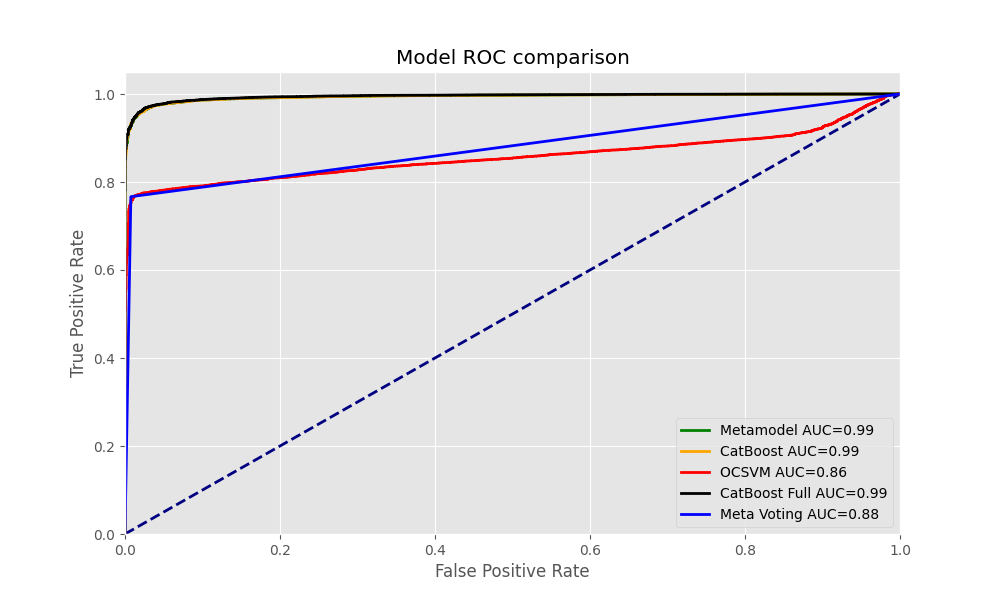

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2780
           1       0.99      0.98      0.99     19569

    accuracy                           0.98     22349
   macro avg       0.94      0.95      0.94     22349
weighted avg       0.98      0.98      0.98     22349

Metamodel confusion matrix:
[[ 2543   237]
 [  305 19264]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2780
           1       0.99      0.98      0.99     19569

    accuracy                           0.98     22349
   macro avg       0.94      0.95      0.94     22349
weighted avg       0.98      0.98      0.98     22349

CatBoost confusion matrix:
[[ 2534   246]
 [  303 19266]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification repo

In [17]:
multi_model_perf(y_test, [test_data['meta_y_pred'], test_data['cat_cl_pred'], test_data['ocsvm_pred'],
                       test_data['full_y_pred'], test_data['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

In [18]:
print('Hardest rendition types:')
test_data['full_y_pred_lab'] = test_data['full_y_pred']>0.5
test_data[test_data.full_y_pred_lab!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
240p_black_and_white        7
360p_watermark-856x856      7
360p_black_and_white        7
240p_watermark-856x856      7
144p_black_and_white        9
1080p_watermark-345x114    13
720p_watermark-345x114     17
360p                       21
480p                       23
480p_watermark-345x114     28
360p_watermark-345x114     35
240p_watermark-345x114     40
240p                       53
144p_watermark-345x114     61
144p                       81
Name: rendition, dtype: int64

In [19]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,4,52.051758,temporal_threshold_gaussian_difference-mean
1,2,14.483031,temporal_gaussian_difference-mean
2,1,14.471797,temporal_dct-mean
3,0,10.962283,size_dimension_ratio
4,3,8.031131,temporal_gaussian_mse-mean


FPS Renditions


<IPython.core.display.Javascript object>


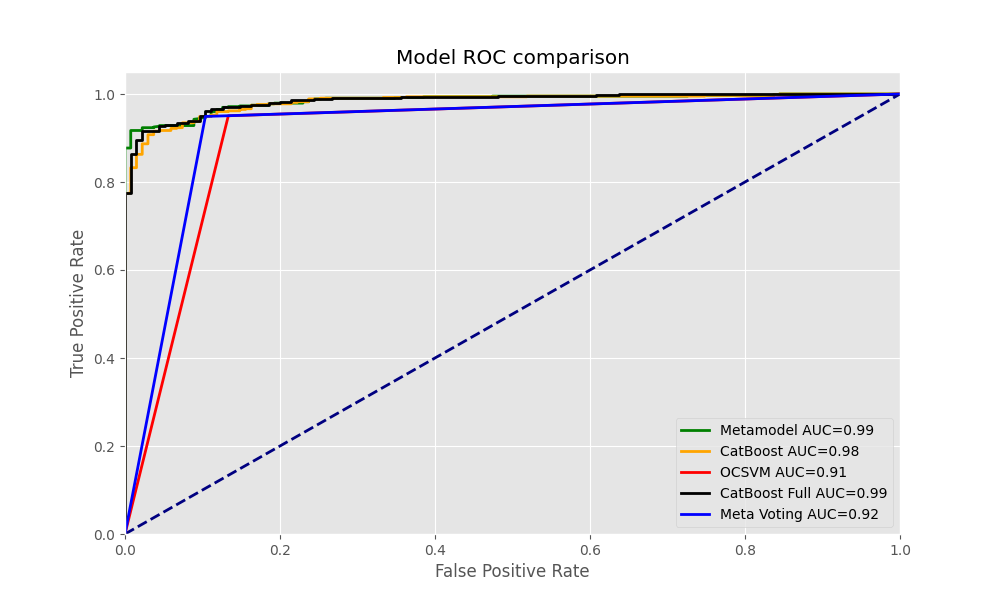

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       135
           1       0.92      0.99      0.96       627

    accuracy                           0.92       762
   macro avg       0.94      0.80      0.85       762
weighted avg       0.93      0.92      0.92       762

Metamodel confusion matrix:
[[ 81  54]
 [  4 623]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       135
           1       0.92      0.99      0.95       627

    accuracy                           0.92       762
   macro avg       0.94      0.79      0.84       762
weighted avg       0.92      0.92      0.92       762

CatBoost confusion matrix:
[[ 80  55]
 [  4 623]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
            

In [20]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_y_pred'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred_label'],
                       test_data[fps_test_idx]['full_y_pred'], test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.9,0.5])

GPU Renditions


<IPython.core.display.Javascript object>


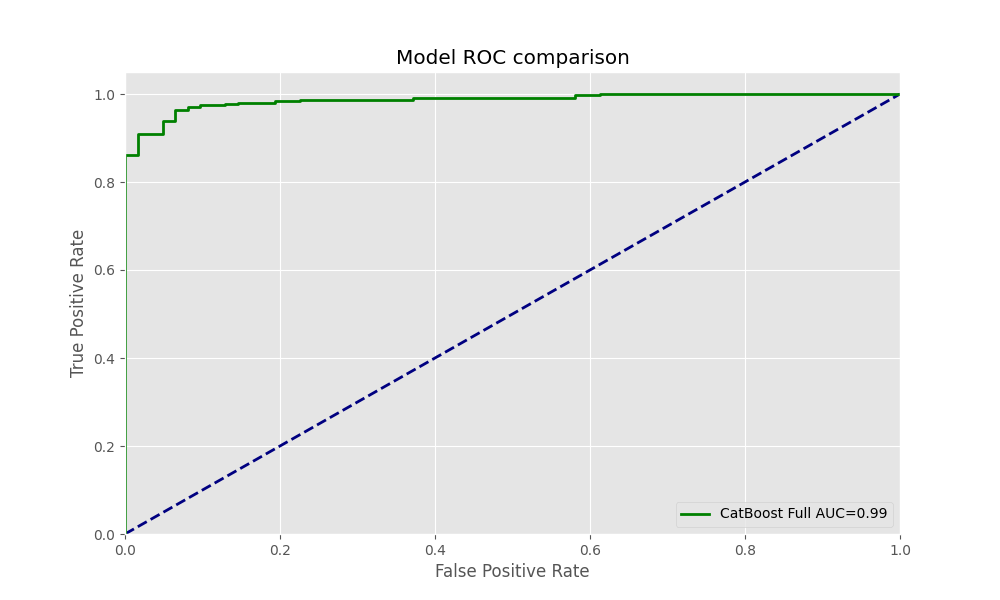

##################
CatBoost Full ROC threshold: 0.5
CatBoost Full classification report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75        62
           1       0.93      0.99      0.96       310

    accuracy                           0.93       372
   macro avg       0.93      0.81      0.85       372
weighted avg       0.93      0.93      0.92       372

CatBoost Full confusion matrix:
[[ 39  23]
 [  3 307]]


In [21]:
print('GPU Renditions')
gpu_test_idx = test_data.id.str.contains('gpu')
y_test_fps = test_data[gpu_test_idx]['target']
gpu_test_data = test_data[gpu_test_idx]
multi_model_perf(y_test_fps, [gpu_test_data['full_y_pred']], 
              ['CatBoost Full'], report_threshold=[0.5])

In [22]:
len(data[data.id.str.contains('fps')])

5397